In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from IPython.display import clear_output

In [2]:
df = pd.read_csv('../data/train.csv', header=0)
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [3]:
target_names = ['1 - Spruce/Fir', '2 - Lodgepole Pine', '3 - Ponderosa Pine', 
                '4 - Cottonwood/Willow', '5 - Aspen', '6 - Douglas-fir',
                '7 - Krummholz']

In [4]:
data = df.drop(['Id', df.columns[len(df.columns) - 1]], axis=1)
data.shape

(15120, 54)

In [5]:
labels = df[df.columns[len(df.columns) - 1]]
labels.shape

(15120,)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.33, random_state=42)

In [7]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

## PCA

In [8]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train_std)

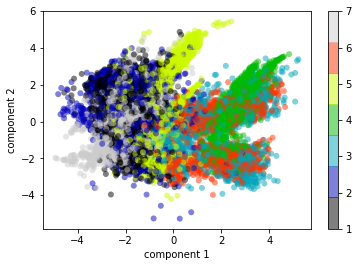

In [9]:
plt.scatter(X_2D[:, 0], X_2D[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 7))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

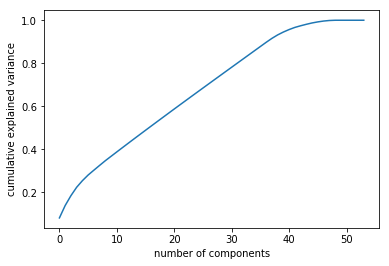

In [10]:
pca = PCA(n_components=54)
pca.fit(X_train_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## SVM

In [76]:
model = make_pipeline(SVC())

In [77]:
param_grid = {
    'svc__kernel': ['linear', 'rbf'],  # 'linear', 'rbf'
    'svc__C': [50, 100, 200],  # 1, 5, 10, 50, 100, 200
    'svc__gamma': [.01, .05, .1]}  # 0.0001, 0.0005, 0.001, 0.005, .01, .1
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
%time grid.fit(X_train_std, y_train)

CPU times: user 4.22 s, sys: 114 ms, total: 4.33 s
Wall time: 4min 30s


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svc__kernel': ['linear', 'rbf'], 'svc__gamma': [0.01, 0.05, 0.1], 'svc__C': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [78]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test_std)

{'svc__kernel': 'rbf', 'svc__gamma': 0.05, 'svc__C': 100}


In [79]:
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.73      0.72      0.73       679
   2 - Lodgepole Pine       0.72      0.65      0.68       722
   3 - Ponderosa Pine       0.80      0.75      0.77       704
4 - Cottonwood/Willow       0.91      0.96      0.93       739
            5 - Aspen       0.88      0.91      0.89       721
      6 - Douglas-fir       0.80      0.83      0.82       722
        7 - Krummholz       0.93      0.97      0.95       703

          avg / total       0.83      0.83      0.83      4990



## Logistic Regression

In [61]:
model = make_pipeline(PCA(), PolynomialFeatures(), LogisticRegression())
c_vals = [1, 2, 4, 10] #[.0001, 0.001, 0.01, 0.1, 1, 2, 4, 10, 20, 50, 100]
tol = [.01]
param_grid = {
    'pca__n_components': range(21, 23),
    'polynomialfeatures__degree': range(1, 3),
    'logisticregression__C': c_vals,
    'logisticregression__tol': tol,
    'logisticregression__penalty': ['l2']
}
grid = GridSearchCV(model, param_grid=param_grid, cv=3, n_jobs=6)
%time grid.fit(X_train_std, y_train)
print('Best params for Logistic Regression: {}'. \
      format(grid.best_params_))

CPU times: user 34.1 s, sys: 242 ms, total: 34.4 s
Wall time: 3min 46s
Best params for Logistic Regression: {'logisticregression__C': 10, 'logisticregression__tol': 0.01, 'pca__n_components': 22, 'logisticregression__penalty': 'l2', 'polynomialfeatures__degree': 2}


In [62]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test_std)

{'logisticregression__C': 10, 'logisticregression__tol': 0.01, 'pca__n_components': 22, 'logisticregression__penalty': 'l2', 'polynomialfeatures__degree': 2}


In [63]:
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.65      0.67      0.66       679
   2 - Lodgepole Pine       0.68      0.54      0.60       722
   3 - Ponderosa Pine       0.68      0.65      0.66       704
4 - Cottonwood/Willow       0.83      0.95      0.89       739
            5 - Aspen       0.79      0.83      0.81       721
      6 - Douglas-fir       0.70      0.71      0.71       722
        7 - Krummholz       0.91      0.90      0.91       703

          avg / total       0.75      0.75      0.75      4990



## GMM

In [109]:
def run_exp(pca_n, gmm_n, cov_type):

    pca = PCA(n_components=pca_n)
    pca.fit(X_train_std)
    X_train_pca = pca.transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)
    
    all_scores = np.zeros(y_test.shape)
    for label in range(1, len(target_names) + 1):
        X = X_train_pca[np.where(y_train == label)]
        gmm = GaussianMixture(n_components=gmm_n,
                              covariance_type=cov_type)
        gmm.fit(X)
        scores = gmm.score_samples(X_test_pca)
        all_scores = np.column_stack((all_scores, scores))
        
    all_scores = np.delete(all_scores, (0), axis=1)
    
    # choose the max index for each row for pred
    y_pred = all_scores.argmax(axis=1)
    y_pred = y_pred + 1
    accuracy = np.mean(y_pred == y_test)
    return accuracy

matrix_types = ('spherical', 'diag', 'tied', 'full')
n_pca_components = range(1, 55)
n_gmm_components = range(1, 55)
accuracies = []

for cov_type in matrix_types:
    for pca_n in n_pca_components:
        for gmm_n in n_gmm_components:
            accuracy = run_exp(pca_n=pca_n, 
                               gmm_n=gmm_n,
                               cov_type=cov_type)
            accuracies.append({'accuracy': accuracy, 'cov_type': cov_type,
                               'pca_n': pca_n, 'gmm_n': gmm_n})
            clear_output()
            print(len(accuracies))

print(sorted(accuracies, key=lambda k: k['accuracy'])[-1])

11664
{'pca_n': 9, 'cov_type': 'full', 'gmm_n': 42, 'accuracy': 0.80781563126252509}
